In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
#sets all plt graphs to a default size
plt.rcParams['figure.figsize'] = (10, 6)

C:\Users\Alvin\Anaconda3\envs\py3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Alvin\Anaconda3\envs\py3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
files = ['connections.csv', 'polled.csv', 'voters.csv']
fpath = ''

In [5]:
#reading files
connection = pd.read_csv(fpath+files[0])
polled = pd.read_csv(fpath+files[1])
voters = pd.read_csv(fpath+files[2])

In [6]:
print(len(connection))
connection.head()

1476973


,source,sink
0,a730d95c0b0bc7641f8d9e12b5387687,60f93ce30d96543e956db25b55e9c9b4
1,da02f77132e4e9886d9e5b29c0837ec3,5685a73addbc6d776f1613332d6e1e45
2,da02f77132e4e9886d9e5b29c0837ec3,f024e10f1cb3822bb76297241438c0b8
3,535cee310cb446eeb2088869df591127,c64d8547dab113d60e521ad43c084b2c
4,535cee310cb446eeb2088869df591127,afc08b53603935f76cf36d9730dae350


This data frame contains information on each voter and their connections.  This will be very useful for engineering graph-like features.

In [7]:
print(len(polled))
polled.head()

651


,uid,choice
0,eaaf41fb22d61e54688139313c6e6906,B
1,f2124b2fa0839b94db567e56cb758ce0,A
2,63413c0060bbedea0a95aded90954cf1,B
3,eb68e1c85633643d6bbdac53147db8ea,A
4,6faa8ff8d09706519939b91d7184c6cc,A


This data contains the polled voters and their vote - this is all the labeled data.

In [8]:
print(len(voters))
voters.head()

354278


,uid,party,demo.age_range,demo.gender,demo.marital_status,demo.ethnicity,demo.children,demo.religion,demo.homeowner,last_4_primary_history,last_4_general_history
0,024cc9efd80fdacd03292a9bd756bf96,democrat,5,m,s,w,u,p,y,2,3
1,0b94f3ba5836825a8ea67870bbc40131,republican,2,m,m,w,y,p,y,4,4
2,03bc3680e7b208a9de1d1e30008dbe86,republican,3,m,s,w,u,p,y,1,4
3,347566dd647fb7c7ba961427151b1ece,republican,3,m,s,s,y,p,y,3,4
4,f00d5df4b6ef6d54fea1f206eee8c8e1,republican,2,f,m,s,y,p,y,3,4


This contains all the voters and their features.  From these features and the labels from the polled dataset, we'd like to predict the votes from the candidates that have not been polled.

Next I use the connections data to engineer new features.  First, I will count the number of connections each voter has.  Then I count the number of differences between the connections' features.  For example, if a voter is female and single, and her connection is male and married, that counts as a difference of 2.

In [9]:
#get num of connections for each source
conn_counts = connection.source.value_counts()

#add num of connections as a voters feature
voters['num_conns'] = connection.source.map(conn_counts)

#join polled df with voters on user id
voters = voters.set_index('uid')
polled = polled.set_index('uid')
polled = polled.join(voters)

In [10]:
%%time
#create new dataframe of connections with the uid's that are polled
#sum the number of differences between the connections' features
connection_polled = connection[connection.source.isin(polled.index)]
connection_polled = connection_polled.reset_index(drop = True)
diff_list = []
for i in range(len(connection_polled)):
    source_data = voters.ix[connection.source[i]]
    sink_data = voters.ix[connection.sink[i]]
    diff_list.append(sum(source_data != sink_data))
connection_polled['differences'] = pd.Series(diff_list)
connection_polled.head()

Wall time: 2.36 s


In [11]:
#get average difference of connections for each polled voter and use as a feature
gp = connection_polled.groupby('source')
polled = polled.join(gp.differences.mean())
#dropping because all samples are republican
polled = polled.drop('party', axis = 1)
polled.head()

,choice,demo.age_range,demo.gender,demo.marital_status,demo.ethnicity,demo.children,demo.religion,demo.homeowner,last_4_primary_history,last_4_general_history,num_conns,differences
uid,,,,,,,,,,,,
eaaf41fb22d61e54688139313c6e6906,B,5,m,s,w,u,p,y,3,4,5,5.8
f2124b2fa0839b94db567e56cb758ce0,A,1,m,s,unknown,y,unknown,y,3,4,5,6.4
63413c0060bbedea0a95aded90954cf1,B,5,f,m,unknown,u,unknown,y,4,4,5,4.4
eb68e1c85633643d6bbdac53147db8ea,A,5,m,m,w,u,p,y,2,4,5,2.0
6faa8ff8d09706519939b91d7184c6cc,A,1,f,s,s,y,p,y,2,4,5,4.8


In [12]:
#Take a look at what values are in each column
for col in polled.columns:
    print('\n', col, ':\n', polled[col].unique())


 choice :
 ['B' 'A']

 demo.age_range :
 [5 1 3 2 4]

 demo.gender :
 ['m' 'f']

 demo.marital_status :
 ['s' 'm']

 demo.ethnicity :
 ['w' 'unknown' 's' 'j' 'e' 'n' 'y' 'f' 'o' 'm']

 demo.children :
 ['u' 'y']

 demo.religion :
 ['p' 'unknown' 'j' 'c' 'o' 'b']

 demo.homeowner :
 ['y' 'n']

 last_4_primary_history :
 [3 4 2]

 last_4_general_history :
 [4 3 2 1 0]

 num_conns :
 [5 3 2 4 1]

 differences :
 [  5.8          6.4          4.4          2.           4.8          4.6
   3.4          6.           6.5                 nan   5.2          6.6
   2.6          5.           6.8          3.8          3.33333333   7.6
   3.2          5.4          3.75         1.5          6.2          2.8
   5.6          4.5          4.25         4.           7.           7.2
   4.2          5.5          5.66666667   4.66666667   3.6          7.4
   3.           8.4          2.2          8.2          8.           2.4
   5.25         4.75         3.5         10.           7.33333333   2.5
   5.33333

What's significant about the above is that there are values of 'unknown' in the demo.ethnicity and demo.religion columns, as well as null values in the differences column.  Since null values will ruin the calculations in machine learning algorithms implemented in scikit learn, these must be dealt with.

In [29]:
preprocess(polled).columns

Index(['last_4_primary_history', 'last_4_general_history', 'num_conns',
       'differences', 'demo.age_range_1', 'demo.age_range_2',
       'demo.age_range_3', 'demo.age_range_4', 'demo.age_range_5',
       'demo.gender_f', 'demo.gender_m', 'demo.marital_status_m',
       'demo.marital_status_s', 'demo.ethnicity_e', 'demo.ethnicity_f',
       'demo.ethnicity_j', 'demo.ethnicity_m', 'demo.ethnicity_n',
       'demo.ethnicity_o', 'demo.ethnicity_s', 'demo.ethnicity_w',
       'demo.ethnicity_y', 'demo.children_u', 'demo.children_y',
       'demo.religion_b', 'demo.religion_c', 'demo.religion_j',
       'demo.religion_o', 'demo.religion_p', 'demo.homeowner_n',
       'demo.homeowner_y', 'choice'],
      dtype='object')

In [13]:
print(polled['demo.ethnicity'].value_counts(), '\n\n', polled['demo.religion'].value_counts())

w          474
unknown     97
s           26
j           18
e           17
y           10
f            4
m            3
n            1
o            1
Name: demo.ethnicity, dtype: int64 

 p          450
unknown     99
c           79
j           18
o            4
b            1
Name: demo.religion, dtype: int64


Since there are a large number of unknowns relative to the number of samples we have, we can't delete the rows with unknown values without losing a lot of information.  Ideally, we'd try to predict this value (using something like a nearest neighbors classifier) but for now I'll just convert the unknown's to the most frequent class for the sake of time.

In [14]:
#replace unknown values with the most common value in the variable
polled.loc[:,'demo.ethnicity'] = polled.loc[:,'demo.ethnicity'].replace('unknown', 'w')
polled.loc[:,'demo.religion'] = polled.loc[:,'demo.religion'].replace('unknown', 'p')

In [156]:
def normalize(df):
    """
    takes in a df and returns it back with normalized data
    """
    for col in df.columns:
        tr_mean = df[col][mask].mean()
        tr_std = df[col][mask].std()
        df[col] = (df[col] - tr_mean)/tr_std
    return df

def preprocess(indf):
    """
    replaces missing values and encodes categorical variables
    """
    subdf = indf.copy()
    # replace missing values with mean
    subdf.differences = subdf.differences.fillna(subdf.differences.mean())
    # normalize numerical variables
    subdf_num_vars = normalize(subdf.ix[:,-4:])
    #check if choice in columns (labelled data vs unlabelled)
    if 'choice' in subdf.columns:
        # one-hot-encode categorical variables
        subdf_cat_vars = pd.get_dummies(subdf.ix[:,1:-4])
        subdf = subdf_num_vars.join(subdf_cat_vars).join(subdf['choice'])
    else:
        # one-hot-encode categorical variables
        subdf_cat_vars = pd.get_dummies(subdf.ix[:,:-4])
        subdf = subdf_num_vars.join(subdf_cat_vars)
    return subdf

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=3, score_func=None):
    """
    grid search for optimal parameters 
    """
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column to predict 
# target1val - particular value to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# score_func - scoring function
# n_folds - Number of folds for cross validation
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, score_func=None, n_folds=5, n_jobs=1):
    # slice dataframe by selected features
    subdf= indf[featurenames].copy()
    X = subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest

In [157]:
#convert demo.age_range to categories so that we can One-Hot-Encode it
polled['demo.age_range'] = polled['demo.age_range'].astype('category', copy = False)

#preprocess the dataset
polled_processed = preprocess(polled)

for col in polled_processed.columns:
    print('\n', col, ':\n', polled_processed[col].value_counts())


 last_4_primary_history :
  0.956589    298
-0.269462    193
-1.495513    160
Name: last_4_primary_history, dtype: int64

 last_4_general_history :
  0.353747    559
-1.821317     72
-3.996380     15
-6.171443      4
-8.346506      1
Name: last_4_general_history, dtype: int64

 num_conns :
  0.330448    578
-2.239706     25
-0.954629     22
-3.524784     16
-4.809861     10
Name: num_conns, dtype: int64

 differences :
 -0.666994    44
 0.003620    43
 0.130503    42
-0.188496    38
 0.290002    37
-0.347995    35
-0.028997    33
 0.449501    31
-0.507494    31
 0.927999    30
-0.826493    23
 0.609000    23
 0.768500    21
-1.464490    18
 1.087498    17
-1.304991    16
 1.406497    15
-0.985992    15
 1.246997    12
-1.623989    11
-2.261986    10
 1.565996    10
 1.725495     8
-1.145491     8
-0.268246     7
 2.522991     6
 0.529251     5
-2.102487     4
-0.467620     4
-1.198658     4
 1.884994     4
-0.135330     4
 2.044494     4
 1.326747     3
-0.932826     3
 2.203993     3

After one hot encoding the features, I look at each feature and the counts for each of its values.  To filter out insignificant features (and reducing dimensionality in doing so), I will remove any feature with only 2 possible values and a count of 5 or less for one of those values. For example, demo.ethnicity_m has possible values 0 and 1, with a distribution of 648 to 3.  Since there are only 3 occurences of the value 1, this variable will be removed.  I believe this will help reduce noise and overfitting.

In [158]:
#loop through every column
for col in polled_processed.columns:
    #check if there are only 2 possible values for that column
    if len(polled_processed[col].value_counts()) == 2:
        #check if count for each of those 2 values is less than 5
        for val_count in polled_processed[col].value_counts():
            if val_count <= 5:
                #drop col if a count is less than 5
                polled_processed = polled_processed.drop(col, axis = 1)

In [159]:
#create train/test mask
itrain, itest = train_test_split(range(polled.shape[0]), train_size=0.7)
mask=np.ones(polled.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [160]:
#get column names as predictors
Xnames = polled_processed.columns.values[:-1]
Xnames

array(['last_4_primary_history', 'last_4_general_history', 'num_conns',
       'differences', 'demo.age_range_1', 'demo.age_range_2',
       'demo.age_range_3', 'demo.age_range_4', 'demo.age_range_5',
       'demo.gender_f', 'demo.gender_m', 'demo.marital_status_m',
       'demo.marital_status_s', 'demo.ethnicity_e', 'demo.ethnicity_j',
       'demo.ethnicity_s', 'demo.ethnicity_w', 'demo.ethnicity_y',
       'demo.children_u', 'demo.children_y', 'demo.religion_c',
       'demo.religion_j', 'demo.religion_p', 'demo.homeowner_n',
       'demo.homeowner_y'], dtype=object)

In [106]:
%%time
from sklearn.ensemble import RandomForestClassifier

#set parameters
parameters = {"max_depth": list(range(5,30)), "max_features": ['auto', 'log2', 0.5, None]}
clfForest = RandomForestClassifier(n_estimators = 100, oob_score = True)

#output random forest model results
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       polled_processed, Xnames, 'choice', 'B', mask=mask, 
                                                       n_jobs = 4, score_func='f1')   

C:\Users\Alvin\Anaconda3\envs\py3\lib\site-packages\ipykernel\__main__.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


using mask
BEST {'max_depth': 9, 'max_features': 'log2'} 0.5904418159277494
############# based on standard predict ################
Accuracy on training data: 0.84
Accuracy on test data:     0.49
[[56 52]
 [48 40]]
########################################################
Wall time: 21.7 s


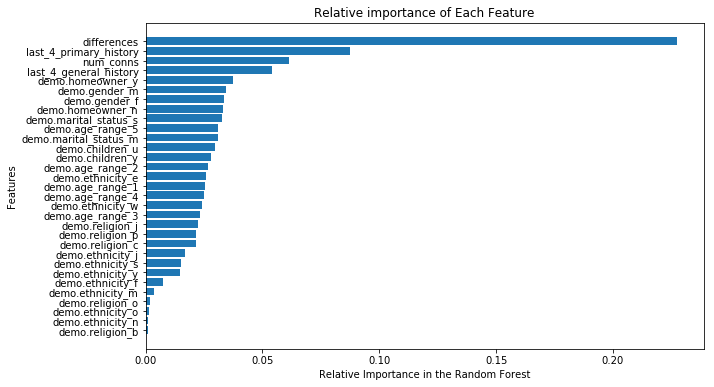

In [21]:
#plot importance of features
importance_list = clfForest.feature_importances_
name_list = Xnames
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [107]:
from xgboost import XGBClassifier
parameters = { 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
XGBmodel = XGBClassifier(max_depth = 5, learning_rate = 0.1, n_estimators = 300, seed=0,  min_child_weight = 4, 
             objective= 'binary:logistic', gamma = 0.3, subsample = 0.7, colsample_bytree = 0.7)
XGBmodel, Xtrain, ytrain, Xtest, ytest = do_classify(XGBmodel, parameters, 
                                                       polled_processed, Xnames, 'choice', 'B', mask=mask, 
                                                       n_jobs = 4, score_func='f1')   

C:\Users\Alvin\Anaconda3\envs\py3\lib\site-packages\ipykernel\__main__.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


using mask
BEST {'reg_alpha': 1e-05} 0.4782984465593161
############# based on standard predict ################
Accuracy on training data: 0.82
Accuracy on test data:     0.49
[[60 48]
 [52 36]]
########################################################


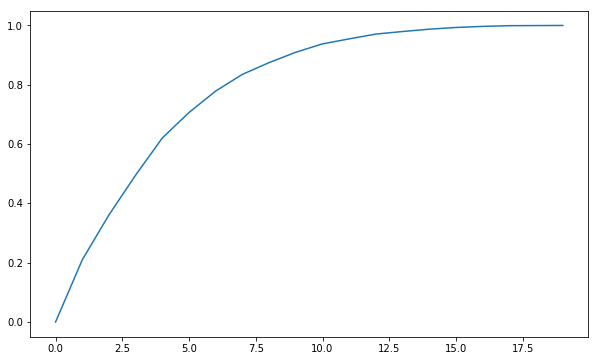

In [185]:
from sklearn.decomposition import PCA

n_comps = list(range(20))
var = []
for i in n_comps:
    pca = PCA(n_components = i)
    X = pca.fit_transform(polled_processed.ix[:,:-1].values)
    var.append(pca.explained_variance_ratio_.sum())

plt.plot(n_comps,var)

In [130]:
pcafeed = polled_processed.ix[:,polled_processed.columns != 'choice']
pca = PCA(n_components=14)
X = pca.fit_transform(pcafeed)
df = pd.DataFrame()
df['choice'] = polled.choice.map({'B': 1, 'A': 0})
for i in range(14):
    df["pc%i" % (i+1)] = X[:,i]

In [132]:
#create train/test mask
itrain, itest = train_test_split(range(df.shape[0]), train_size=0.7)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

#set features
pcaXnames = ["pc%i" % (i+1) for i in range(14)]

#normalize data
df[pcaXnames] = normalize(df[pcaXnames])

C:\Users\Alvin\Anaconda3\envs\py3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [133]:
from sklearn.ensemble import RandomForestClassifier

#set parameters
parameters = {"max_depth": list(range(5,30)), "max_features": ['auto', 'log2', 0.5]}
clfForest = RandomForestClassifier(n_estimators = 500, oob_score = True)

clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       df, pcaXnames, 'choice', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')   

C:\Users\Alvin\Anaconda3\envs\py3\lib\site-packages\ipykernel\__main__.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


using mask
BEST {'max_depth': 7, 'max_features': 'auto'} 0.5194358116184556
############# based on standard predict ################
Accuracy on training data: 0.93
Accuracy on test data:     0.50
[[55 54]
 [44 43]]
########################################################


In [134]:
from xgboost import XGBClassifier
parameters = {'max_depth': list(range(5,20)), 'min_child_weight': list(range(1,6))}
XGBmodel = XGBClassifier(learning_rate = 0.1, n_estimators = 300, seed=0, subsample =0.8, colsample_bytree= 0.8, 
             objective= 'binary:logistic')
XGBmodel, Xtrain, ytrain, Xtest, ytest = do_classify(XGBmodel, parameters, 
                                                       df, pcaXnames, 'choice', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')   

using mask


C:\Users\Alvin\Anaconda3\envs\py3\lib\site-packages\ipykernel\__main__.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'max_depth': 14, 'min_child_weight': 1} 0.5091726296783828
############# based on standard predict ################
Accuracy on training data: 0.97
Accuracy on test data:     0.55
[[59 50]
 [39 48]]
########################################################


<font size = 5> The disparity between the training and testing scores of the model signals overfitting.  All models have ~50% accuracy on the test data, which is not too far off of the distribution of the votes between A and B, so the models won't be very useful at all.  I think I need to come up with more meaningful features from feature engineering with the connection data.  However, for the sake of demonstrating the use case of the predictive model, I will proceed to predicting the votes for the unpolled voters.</font>

In [120]:
%%time
#calculate "number of differences" feature for each connection
diff_list = []
for i in range(len(connection)):
    source_data = voters.ix[connection.source[i]]
    sink_data = voters.ix[connection.sink[i]]
    diff_list.append(sum(source_data != sink_data))
connection['differences'] = pd.Series(diff_list)
connection.head()

Wall time: 20min 15s


In [121]:
#get average difference of connections for each voter and include as a feature
gp = connection.groupby('source')
voters = voters.join(gp.differences.mean())
voters.head()

,party,demo.age_range,demo.gender,demo.marital_status,demo.ethnicity,demo.children,demo.religion,demo.homeowner,last_4_primary_history,last_4_general_history,num_conns,differences
uid,,,,,,,,,,,,
024cc9efd80fdacd03292a9bd756bf96,democrat,5,m,s,w,u,p,y,2,3,1,7.0
0b94f3ba5836825a8ea67870bbc40131,republican,2,m,m,w,y,p,y,4,4,2,4.2
03bc3680e7b208a9de1d1e30008dbe86,republican,3,m,s,w,u,p,y,1,4,2,4.4
347566dd647fb7c7ba961427151b1ece,republican,3,m,s,s,y,p,y,3,4,5,5.6
f00d5df4b6ef6d54fea1f206eee8c8e1,republican,2,f,m,s,y,p,y,3,4,5,6.4


In [122]:
#dropping party again
voters = voters.drop('party', axis = 1)

In [207]:
#drop the people who have already been polled. don't want overlapping train/test sets
voters = voters.drop(polled.index, axis = 0)

I will now preprocess the voters data the same way I did with the polled data frame.

In [145]:
print(voters['demo.ethnicity'].value_counts(), '\n\n', voters['demo.religion'].value_counts())

w          213847
unknown     96135
y           13525
s            8998
j            7773
e            6025
f            3331
m            2059
o            1497
i             376
a             260
p             224
n             175
c              47
t               6
Name: demo.ethnicity, dtype: int64 

 p          197448
unknown     96378
c           49406
j            7773
b            1089
o             881
i             500
g             315
h             232
s             181
l              72
k               3
Name: demo.religion, dtype: int64


Again, it would be much better practice to use a nearest neighbors algorithm to guess the unknown values, but I'm going to replace it with the most common value for the sake of time and efficiency.

In [146]:
#replace unknown values with the most common value in the variable
voters.loc[:,'demo.ethnicity'] = voters.loc[:,'demo.ethnicity'].replace('unknown', 'w')
voters.loc[:,'demo.religion'] = voters.loc[:,'demo.religion'].replace('unknown', 'p')

In [173]:
#convert demo.age_range to categories so that we can One-Hot-Encode it
voters['demo.age_range'] = voters['demo.age_range'].astype('category', copy = False)

#preprocess the dataset
voters_processed = preprocess(voters)

C:\Users\Alvin\Anaconda3\envs\py3\lib\site-packages\pandas\core\internals.py:252: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 354278 but corresponding boolean dimension is 651
  return self.values[slicer]
C:\Users\Alvin\Anaconda3\envs\py3\lib\site-packages\pandas\indexes\base.py:1434: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 354278 but corresponding boolean dimension is 651
  result = getitem(key)


Since many of these columns didn't exist in the polled dataframe, I will delete them from the voters dataframe since the model wouldn't know what to do with that extra information.

In [178]:
#drop columns in voters that were not in poled
for col in voters_processed.columns:
    if col not in polled_processed.columns:
        voters_processed = voters_processed.drop(col, axis = 1)

In [189]:
#Get principal components
pcafeed = voters_processed
pca = PCA(n_components=14)
X = pca.fit_transform(pcafeed)
df = pd.DataFrame()
for i in range(14):
    df["pc%i" % (i+1)] = X[:,i]

In [190]:
#get the probability for each person
probs = clfForest.predict_proba(df.values)

In [191]:
#Put into a dataframe
probsdf = pd.DataFrame({"Prob_sup_B":[x[1] for x in probs]}, index = voters.index)

In [192]:
#Join original voters dataframe with prob dataframe
voters = voters.join(probsdf)
voters

,demo.age_range,demo.gender,demo.marital_status,demo.ethnicity,demo.children,demo.religion,demo.homeowner,last_4_primary_history,last_4_general_history,num_conns,differences,Prob_sup_B
uid,,,,,,,,,,,,
024cc9efd80fdacd03292a9bd756bf96,5,m,s,w,u,p,y,2,3,1,7.0,0.497748
0b94f3ba5836825a8ea67870bbc40131,2,m,m,w,y,p,y,4,4,2,4.2,0.505679
03bc3680e7b208a9de1d1e30008dbe86,3,m,s,w,u,p,y,1,4,2,4.4,0.394149
347566dd647fb7c7ba961427151b1ece,3,m,s,s,y,p,y,3,4,5,5.6,0.457522
f00d5df4b6ef6d54fea1f206eee8c8e1,2,f,m,s,y,p,y,3,4,5,6.4,0.524251
a573798949629edfb72937ffa147da79,4,f,s,w,u,p,n,1,3,5,5.2,0.449318
2472dd5b118b71af8a7633ebf61d801b,5,f,s,w,u,p,y,3,4,5,6.6,0.591591
f814ed302c3f738df193b0be39f7f3b1,4,f,m,w,u,c,y,4,4,5,2.0,0.479925
325b8f303804daadf4f3bb0bb5e35b3b,5,f,s,w,u,p,y,2,4,4,5.0,0.572796


In [193]:
#Get top 50000 people with highest probability of supporting candidate B
largest = voters['Prob_sup_B'].nlargest(50000)

In [194]:
largest

uid
8362259b0cefed827df2921259d53b87    0.756555
f9e2b6f783a259749550a8513cfbc4ce    0.745990
3bf58612dd1dcfc1461c5d4e165974a6    0.737068
776bfc5ae33914c42ee4e6e303c497fd    0.736374
e597998a68e62fa53bd896d827005820    0.736052
d203ed17fdf63969187f5ecb833f48af    0.736052
b53fd8cf2bf96b94d571f2119f662290    0.735966
ec24a6b11be60a94fb614e5756f0aacc    0.734610
d8f3f85b5e9c3cd62762f7598bf12b9a    0.734610
0ec0ff562fe8c954e3125ee03723dbf0    0.734610
1515b652816d9a6b237828440a2b3ff5    0.734610
d098b09a68819bba9c6f27b208fd43a8    0.734518
8d73c774158fd99019a1ef076f695a91    0.728125
caca5785890ee16d654f034043b9521b    0.725244
a4d0d4be3ee45a9f653d1ba0fc125fad    0.723882
d71bfe7c2fb40b8b6c65ddbc0cdb719a    0.723117
ab00692f18ed8650abfb38243fd56e8e    0.723117
b99f824ffbad7d42fcdda3a30833d9a4    0.722758
ff929625e0e80f676ddda47664de3502    0.722697
47e5dd6c86a711eed2fe2edfe8a54d2a    0.722554
057b4dc9094af6bf9a11bc12a5a0c34f    0.721892
deda923307fd42f683de97aa1256aa28    0.721397
d3e9ed